Algorithme des $k$ plus proches voisins pour la discrimination binaire
---
Importer les données simulées des fichiers `nearsep1.txt`, `nearsep2.txt` et `nonsep.txt`.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(library(e1071))
suppressWarnings(library(caret))
suppressWarnings(library(ggpubr))
suppressWarnings(library(doParallel))
library(class)

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loading required package: iterators
Loading required package: parallel


In [2]:
datasep <- list()
for (data in c("nearsep1", "nearsep2", "nonsep")){
    datasep[[data]] <- read_delim(paste0("../data/",data,".txt"), delim = ";", col_types = "_fdd")
}

Transformer la variable d’intérêt `Y` en facteur si besoin, représenter graphiquement les points de coordonnées `X1` et `X2`, en distinguant par des symboles et/ou des couleurs différents les points correspondant aux sorties égales à 1 des points correspondant aux sorties égales à -1.

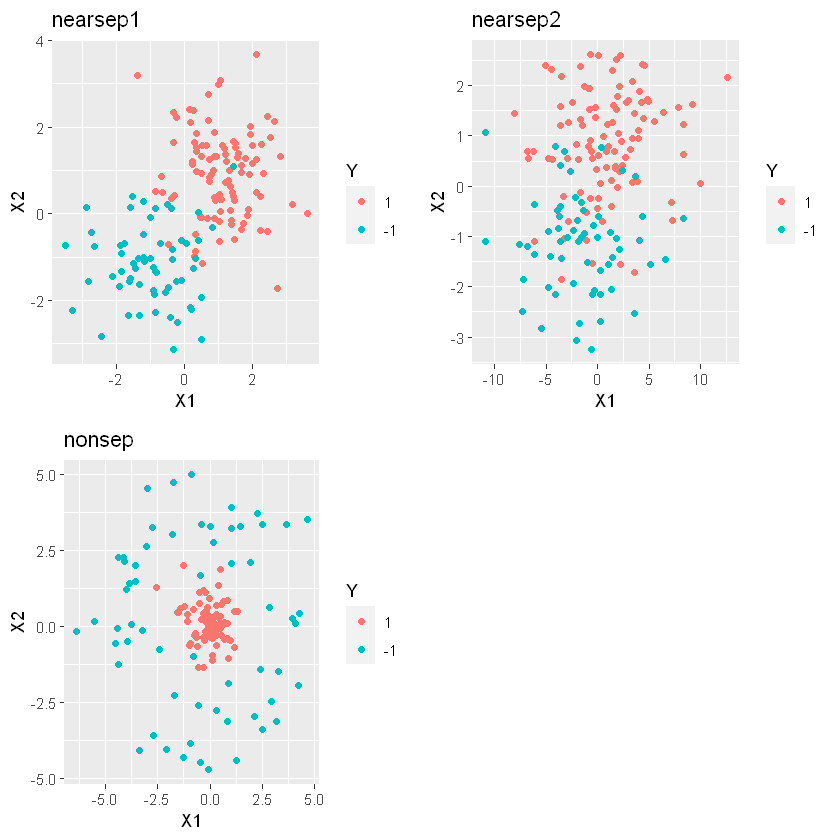

In [3]:
plotlist <- list()
for (data in c("nearsep1", "nearsep2", "nonsep")){
    plotlist[[data]] <- ggplot(datasep[[data]]) +
    aes(X1, X2, color = Y) +
    geom_point() + labs(title = data)
}

ggarrange(plotlist = plotlist)

Estimer le risque moyen de l’algorithme $k$ plus proches voisins par validation hold out pour $k$ = 1,3,96 en utilisant la fonction `knn` du package `class`.

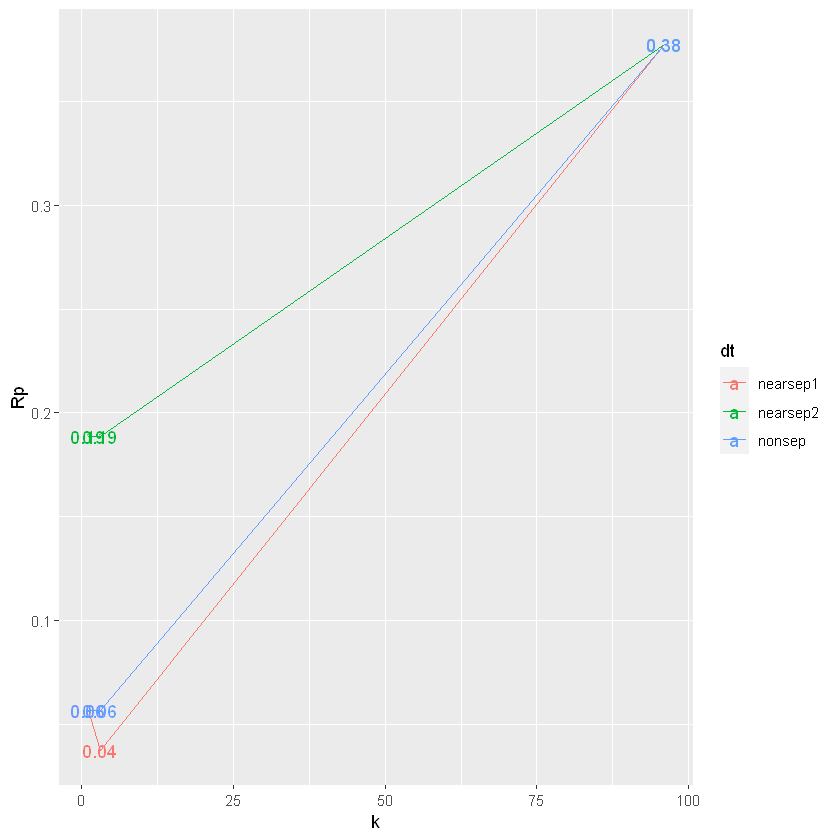

In [4]:
result <- tibble(k = numeric(), dt = character(), Rp = numeric())
for (data in c("nearsep1", "nearsep2", "nonsep")){
    df <- datasep[[data]]
    part <- createDataPartition(df$Y, p = 2/3)
    X_train <- df[part$Resample1, 2:3]
    X_test <- df[-part$Resample1, 2:3]
    y_train <- df[part$Resample1, 1, drop = T]
    y_test <- df[-part$Resample1, 1, drop = T] %>% as.character %>% as.numeric
    
    for (k in c(1,3,96)){
        y_pred <- knn(X_train, X_test, cl = y_train, k = k) %>% 
            as.character %>% as.numeric
        risk <- mean((y_test - y_pred)^2/4)
        result <- result  %>% bind_rows(tibble(
            k = k, dt = data, Rp = risk
        ))
    }
}

result %>% 
ggplot() + aes(x = k, y = Rp, color = dt) + 
geom_line() + geom_text(aes(label = sprintf("%0.2f", Rp)))

Faire la même chose à l’aide des fonctions `tune.knn` et `plot.tune` du package `e1071` pour $k$ = 1,...,120. Que remarque-t-on ? Était-ce prévisible ?

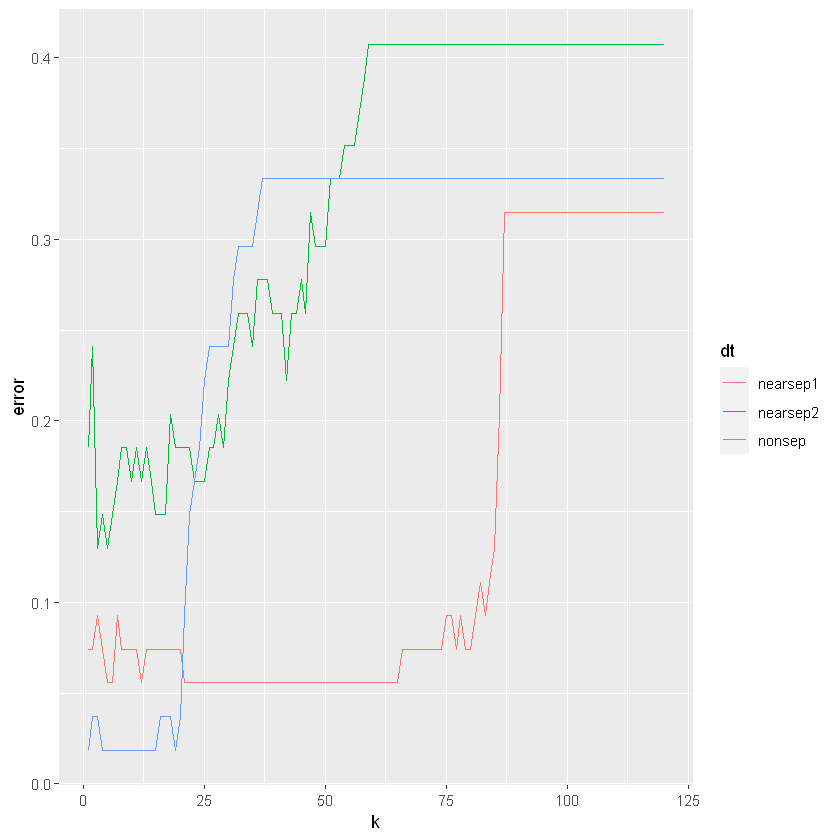

In [5]:
result <- tibble(k = numeric(), error = numeric(), dt = character())
for (data in c("nearsep1", "nearsep2", "nonsep")){
    df <- datasep[[data]]
    tuned <- suppressWarnings(tune.knn(
        x = df[,2:3], y = df[,1, drop = T],
        k = 1:120, tunecontrol = tune.control(sampling = "fix")))
    performances <- tuned$performances %>% 
        select(-dispersion) %>% 
        mutate(dt = data)
    result <- result %>% bind_rows(performances)
}

result %>% 
ggplot() + aes(x = k, y = error, color = dt) + 
geom_line()

Estimer le risque moyen de l’algorithme des $k$ plus proches voisins par validation croisée 10-fold, puis par validation croisée Leave-One-Out pour $k$ = 1,...,120 à l’aide des fonctions `tune.knn` et `plot.tune`

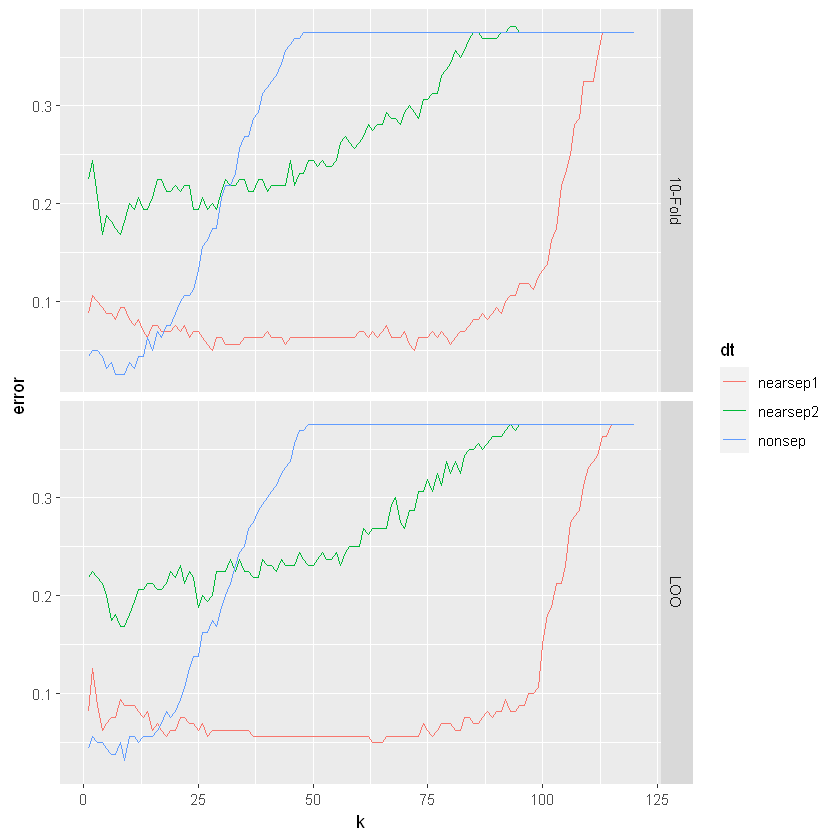

In [6]:
result <- tibble(k = numeric(), error = numeric(), dt = character(), cv = character())
for (data in c("nearsep1", "nearsep2", "nonsep")){
    df <- datasep[[data]]
    cl <- makePSOCKcluster(6)
    registerDoParallel(cl)
    fold <- suppressWarnings(tune.knn(
        x = df[,2:3], y = df[,1, drop = T],
        k = 1:120, tunecontrol = tune.control(sampling = "cross"), cross = 10))
    loo <- suppressWarnings(tune.knn(
        x = df[,2:3], y = df[,1, drop = T],
        k = 1:120, tunecontrol = tune.control(sampling = "cross"), cross = nrow(df)))
    on.exit(stopCluster(cl))
    performances <- fold$performances %>% 
        mutate(cv = "10-Fold") %>% 
        bind_rows((loo$performances %>% mutate(cv = "LOO"))) %>% 
        select(-dispersion) %>% 
        mutate(dt = data)
    result <- result %>% bind_rows(performances)
}

result %>% 
ggplot() + aes(x = k, y = error, color = dt) + 
geom_line() + facet_grid(cv~.)

Pareil, à l’aide de la fonction `train` du package `caret`.

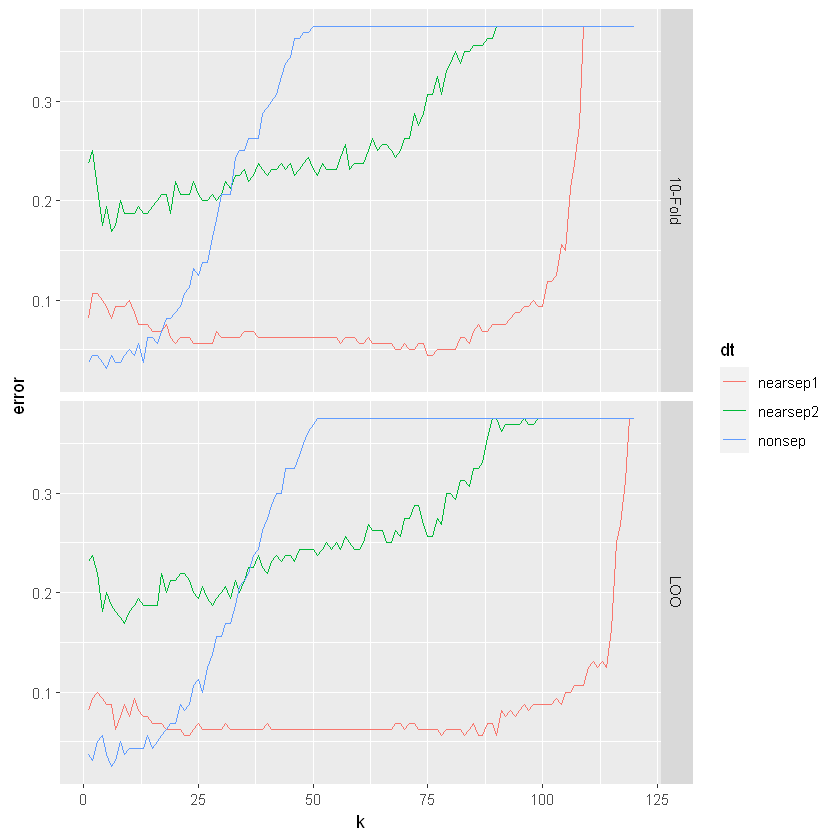

In [7]:
result <- tibble(k = numeric(), error = numeric(), dt = character(), cv = character())
for (data in c("nearsep1", "nearsep2", "nonsep")){
    df <- datasep[[data]]
    cl <- makePSOCKcluster(6)
    registerDoParallel(cl)
    fold <- suppressWarnings(train(
        Y~., data = df, method = "knn",
        trControl = trainControl(method = "cv", number = 10), tuneGrid = data.frame(k = 1:120)))
    loo <- suppressWarnings(train(
        Y~., data = df, method = "knn",
        trControl = trainControl(method = "LOOCV"), tuneGrid = data.frame(k = 1:120)))
    on.exit(stopCluster(cl))
    performances <- fold$results %>% 
        mutate(cv = "10-Fold", error = 1-Accuracy) %>% 
        bind_rows((loo$results %>% mutate(cv = "LOO", error = 1-Accuracy))) %>% 
        mutate(dt = data) %>% 
        select(k, error, dt, cv)
    result <- result %>% bind_rows(performances)
}

result %>% 
ggplot() + aes(x = k, y = error, color = dt) + 
geom_line() + facet_grid(cv~.)